In [ ]:
%pip install pandas
%pip install duckdb
%pip install seaborn[stats]
%pip install matplotlib
%pip install scipy

**Big Data Aproach**

Ada beberapa aproach yang bisa dilakukan untuk EDA dengan data yang besar, scale dari data juga berpengaruh for example, data 2M yang digunakan di nomor 2 mungkin tidak cukup jika menggunakan plain pandas, alternatif solusi lain:

1. Gunakan optimized pandas aproach for big data, e.g. perbanyak vectorized operation instead of row wise operation (Approach that I will use)
2. (Aproach yang akan saya gunakan) Use library that natively supports big data in local machine, ini yang biasa saya pakai, duckdb, columnardb tapi local based spt sqlite, easy to use, does not use up memory
3. Gunakan spark / hadoop / solusi big data lain, yang melakukan operasi map reduce, untuk aproach divide and conquer (overkill)


Saya akan menggunakan approach nomor 2, simpler, easy to use, similar impact, middle of the road option



# EDA (Exploratory Data Analysis)

**The whole EDA, feature engineering, insight, is going to still use the same aproach, but with a different tools and codes**

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import duckdb as db
from scipy import stats


con = db.connect()
con.execute("""
    CREATE OR REPLACE TABLE customers AS
    SELECT * FROM read_csv_auto('data/customers-2000000.csv')
""")

# 1. schema & head 
print('Column dtypes:\n')
print(
    con.execute("PRAGMA table_info('customers')")
      .df()[['name', 'type']]
)

print('\nHead:\n')
print(con.execute("SELECT * FROM customers LIMIT 5").df())

# 2. sanity checks, codenya agak berbeda tapi aproachnya sama 
rows = con.execute("SELECT COUNT(*) FROM customers").fetchone()[0]
cols = con.execute("PRAGMA table_info('customers')").df().shape[0]
print(f'Columns, Rows: ({cols}, {rows})')

dup_rows = con.execute("""
    SELECT SUM(cnt)-COUNT(*) AS dup_rows
    FROM (
      SELECT COUNT(*) cnt
      FROM customers
      GROUP BY ALL
    )
""").fetchone()[0]
print('\nDuplicate rows:', dup_rows)

cust_dup = con.execute("""
    SELECT COUNT(*)-COUNT(DISTINCT "Customer Id")
    FROM customers
""").fetchone()[0]
print('Duplicate customer id:', cust_dup)

# ─── 3. helper for duplicate summaries ──────────────────────────────────────
def duplicate_summary(expr, label, top_n=5):
    print(f"Duplicate Summary for label {label}")
    query = f"""
      WITH dups AS (
        SELECT {expr} AS key, COUNT(*) cnt
        FROM customers
        GROUP BY key
        HAVING cnt > 1
      )
      SELECT COUNT(*) AS grp_cnt,
             SUM(cnt)  AS row_cnt
      FROM dups
    """
    grp_cnt, row_cnt = con.execute(query).fetchone()
    print(f'\n=== {label} ===')
    print(f'Duplicate groups : {grp_cnt}')
    print(f'Rows involved : {row_cnt}')
    if grp_cnt:
        top = con.execute(f"""
          SELECT key, cnt
          FROM (
            SELECT {expr} AS key, COUNT(*) cnt
            FROM customers
            GROUP BY key
            HAVING cnt > 1
          )
          ORDER BY cnt DESC
          LIMIT {top_n}
        """).df()
        print(top)

duplicate_summary('"Company"', 'Company')
duplicate_summary('"Company"||\' \'||"City"', 'Company + City')
duplicate_summary('"Email"', 'Email')
duplicate_summary('"Phone 1"', 'Phone 1')
duplicate_summary('"First Name"||\' \'||"Last Name"', 'First + Last')


Column dtypes:

                 name     type
0               Index   BIGINT
1         Customer Id  VARCHAR
2          First Name  VARCHAR
3           Last Name  VARCHAR
4             Company  VARCHAR
5                City  VARCHAR
6             Country  VARCHAR
7             Phone 1  VARCHAR
8             Phone 2  VARCHAR
9               Email  VARCHAR
10  Subscription Date     DATE
11            Website  VARCHAR

Head:

   Index      Customer Id First Name Last Name                  Company  \
0      1  4962fdbE6Bfee6D        Pam    Sparks             Patel-Deleon   
1      2  9b12Ae76fdBc9bE       Gina     Rocha  Acosta, Paul and Barber   
2      3  39edFd2F60C85BC    Kristie     Greer                Ochoa PLC   
3      4  Fa42AE6a9aD39cE     Arthur    Fields               Moyer-Wang   
4      5  F5702Edae925F1D   Michelle   Blevins            Shah and Sons   

               City                                            Country  \
0        Blakemouth  British Indian Ocean Territ

**Same insight dengan nomor 1** 

In [8]:
import re
from urllib.parse import urlparse

main_df = pd.read_csv("data/customers-2000000.csv")
con = db.connect()
con.register("main_df", main_df)

def split_phone(raw) -> pd.Series:
    # Yes phone number gk ada yang null, tapi just in case
    raw = str(raw) if pd.notna(raw) else ""
    raw = raw.strip()
    
    cc = ""
    body = raw
    
    # Pisahkan CC jadi column sendiri 
    if raw.startswith("+"):
        m = re.match(r"^\+(\d{1,3})", raw)
        if m:
            cc = m.group(1)
            # Rest of the numbers will be taken as standard phone number, extension nanti dibuang though
            body = raw[len(m.group(0)):]
    elif raw.startswith("00"):
        m = re.match(r"^00(\d{1,3})", raw)
        if m:
            cc = m.group(1)
            body = raw[len(m.group(0)):]
    
    # Remove extension, assume uneeded data
    body = re.split(r"(?:ext\.?|x)", body, flags=re.I)[0]
    
    # Keep digits only
    digits = re.sub(r"\D", "", body)
    
    return pd.Series({"phone_std": digits, "phone_cc": cc})

main_df[["Phone 1 Standard", "Phone 1 CC"]] = main_df["Phone 1"].apply(split_phone)
main_df[["Phone 2 Standard", "Phone 2 CC"]] = main_df["Phone 2"].apply(split_phone)

def enrich_website(url) -> pd.Series:
    # Buying power diambil dari price bucket top level domain per company
    # Possible indicator to segment customer (?)
    if pd.isna(url) or not str(url).strip():
        return pd.Series({"website_domain": "", "website_tld": "", "buying_power": "unknown"})

    host = (urlparse(str(url)).hostname or "").lower()
    tld  = host.split(".")[-1] if host else ""

    # I searched for typical pricing on tld's that are mentioned in the data, 
    # Typically premium costs around 200+ USD
    # Mid is 100$ below
    # Budget is even less (xyz, etc)
    if   tld in {"com", "io", "ai", "biz"}:           
        bucket = "premium"
    elif tld in {"net", "org", "co", "info"}:          
        bucket = "mid"
    elif tld:                                  
        bucket = "budget"
    else:                                      
        bucket = "unknown"

    return pd.Series({"website_domain": host, "website_tld": tld, "buying_power": bucket})

main_df[["Website Domain", "Website TLD", "Website Buying Power"]] = main_df["Website"].apply(enrich_website)

main_df['Subscription Date'] = pd.to_datetime(main_df['Subscription Date'], errors='coerce')

In [11]:
import pandas as pd
import numpy as np
from urllib.parse import urlparse

def prep_phone(col: str, prefix: str):
    s = main_df[col].fillna("").str.strip()

    # Country code (digits up to 3 from the beginning of the numbers)
    cc = (
        s.str.extract(r'^\+(\d{1,3})')
         .fillna(s.str.extract(r'^0(\d{1,3})'))
         .fillna("")
         [0]
    )

    body = (
        s.str.replace(r'^\+\d{1,3}|^0\d{1,3}', '', regex=True)
         .str.split(r'(?:ext\.?|x)', n=1, expand=True)[0]
         .str.replace(r'\D', '', regex=True)
    )

    main_df[f"{prefix} CC"] = cc
    main_df[f"{prefix} Standard"] = body

prep_phone("Phone 1", "Phone 1")
prep_phone("Phone 2", "Phone 2")

# Should be much faster than previous method
hosts  = main_df["Website"].fillna("").str.extract(r'https?://([^/]+)')[0].str.lower()
tlds   = hosts.str.extract(r'\.([a-z0-9]+)$')[0].fillna("")

premium = {"com","io","ai","biz"}
mid     = {"net","org","co","info"}

bucket = np.select(
    [tlds.isin(premium), tlds.isin(mid), tlds != ""],
    ["premium", "mid", "budget"],
    default="unknown"
)

main_df["Website Domain"] = hosts
main_df["Website TLD"] = tlds
main_df["Website Buying Power"] = bucket

main_df["Subscription Date"] = pd.to_datetime(main_df["Subscription Date"], errors="coerce")


In [12]:
main_df.head()

,Index,Customer Id,First Name,Last Name,Company,City,Country,Phone 1,Phone 2,Email,Subscription Date,Website,Phone 1 Standard,Phone 1 CC,Phone 2 Standard,Phone 2 CC,Website Domain,Website TLD,Website Buying Power
0,1,4962fdbE6Bfee6D,Pam,Sparks,Patel-Deleon,Blakemouth,British Indian Ocean Territory (Chagos Archipe...,267-243-9490x035,480-078-0535x889,nicolas00@faulkner-kramer.com,2020-11-29,https://nelson.com/,2672439490,,4800780535,,nelson.com,com,premium
1,2,9b12Ae76fdBc9bE,Gina,Rocha,"Acosta, Paul and Barber",East Lynnchester,Costa Rica,027.142.0940,+1-752-593-4777x07171,yfarley@morgan.com,2021-01-03,https://pineda-rogers.biz/,1420940,27,7525934777,1,pineda-rogers.biz,biz,premium
2,3,39edFd2F60C85BC,Kristie,Greer,Ochoa PLC,West Pamela,Ecuador,+1-049-168-7497x5053,+1-311-216-7855,jennyhayden@petty.org,2021-06-20,https://mckinney.com/,0491687497,1,3112167855,1,mckinney.com,com,premium
3,4,Fa42AE6a9aD39cE,Arthur,Fields,Moyer-Wang,East Belinda,Afghanistan,001-653-754-7486x65787,521-630-3858x953,igrimes@ruiz-todd.org,2020-02-13,https://dominguez.biz/,6537547486,01,5216303858,,dominguez.biz,biz,premium
4,5,F5702Edae925F1D,Michelle,Blevins,Shah and Sons,West Jared,Marshall Islands,8735278329,(633)283-6034x500,diamondcarter@jordan.com,2020-10-20,http://murillo-ryan.com/,8735278329,,6332836034,,murillo-ryan.com,com,premium


None
None
None
None
None
None
Value 70365
{'last': np.int64(70365), 'mean_prev': np.float64(68895.0), 'p_value': np.float64(0.9432045331544), 'is_anomaly': np.False_}
Value 70111
{'last': np.int64(70111), 'mean_prev': np.float64(68911.83333333333), 'p_value': np.float64(0.90909402225018), 'is_anomaly': np.False_}
Value 67861
{'last': np.int64(67861), 'mean_prev': np.float64(69625.16666666667), 'p_value': np.float64(0.00705403084642748), 'is_anomaly': np.True_}
Value 70780
{'last': np.int64(70780), 'mean_prev': np.float64(69189.16666666667), 'p_value': np.float64(0.9859926566482704), 'is_anomaly': np.False_}
Value 68145
{'last': np.int64(68145), 'mean_prev': np.float64(69634.33333333333), 'p_value': np.float64(0.018190922999423934), 'is_anomaly': np.True_}
Value 70413
{'last': np.int64(70413), 'mean_prev': np.float64(69234.33333333333), 'p_value': np.float64(0.9599030037266589), 'is_anomaly': np.False_}
Value 70404
{'last': np.int64(70404), 'mean_prev': np.float64(69612.5), 'p_value': n

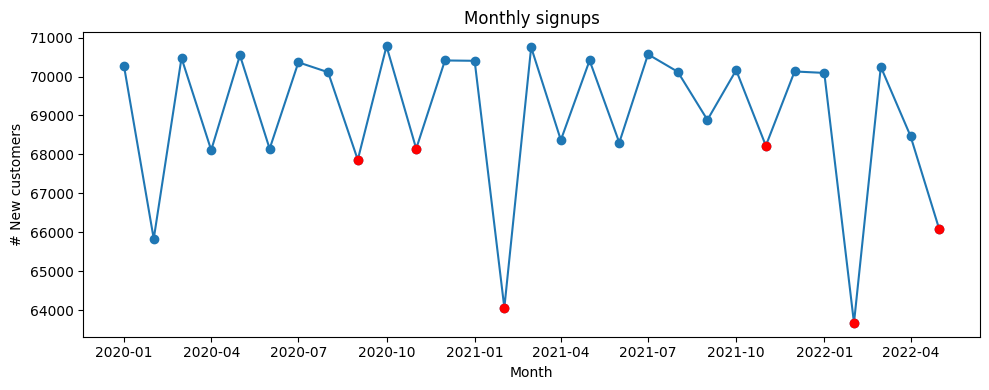

In [13]:

# Function to check the statistical significance of each drop, because i saw a large drop in february 2021, might be valuable insight for business for RCA
def drop_anomaly(series: pd.Series,
                 lookback: int = 6):
    y_last = series.iloc[-1]
    if len(series) < lookback + 1:
        return

    y_last = series.iloc[-1]
    baseline = series.iloc[-lookback-1:-1]

    # Simple one sided t-test
    mean = baseline.mean()
    sd = baseline.std()
    n  = len(baseline)
    error = sd / np.sqrt(n)

    t_stat = (y_last - mean) / error
    p_val  = stats.t.cdf(t_stat, df=n-1)
    
    print(f"Value {y_last}")

    return dict(last=y_last,
                mean_prev=mean,
                p_value=p_val,
                is_anomaly=p_val < 0.05)

monthly = main_df.groupby(main_df['Subscription Date'].dt.to_period('M')).size().sort_index()

is_anomaly = []
for i, datapoint in enumerate(monthly):
    result = drop_anomaly(monthly[:i+1], lookback=6)
    print(result)
    if result and result["is_anomaly"]:
        is_anomaly.append(True)
    else:
        is_anomaly.append(False)


fig1 = plt.figure(figsize=(10,4))
# highlight anomalies
anom_x = monthly.index.to_timestamp()[is_anomaly]
anom_y = monthly.values[is_anomaly]
plt.scatter(anom_x, anom_y, color='red', zorder=5, label='Anomaly')
plt.plot(monthly.index.to_timestamp(), monthly.values, marker='o', label='Monthly signups')
plt.title('Monthly signups')
plt.xlabel('Month')
plt.ylabel('# New customers')
plt.tight_layout()
plt.show()


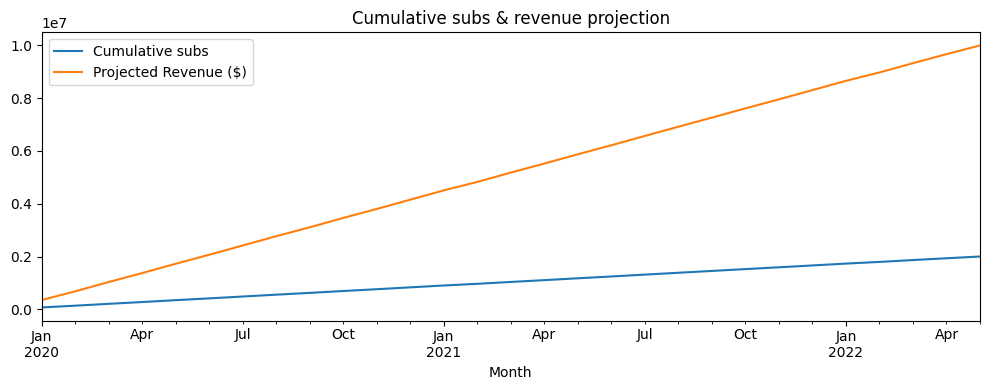

In [14]:
cum_subs = monthly.cumsum()
revenue  = cum_subs * 5

fig2 = plt.figure(figsize=(10,4))
cum_subs.plot(label='Cumulative subs')
revenue.plot(label='Projected Revenue ($)')
plt.title('Cumulative subs & revenue projection')
plt.xlabel('Month')
plt.legend()
plt.tight_layout()
plt.show()

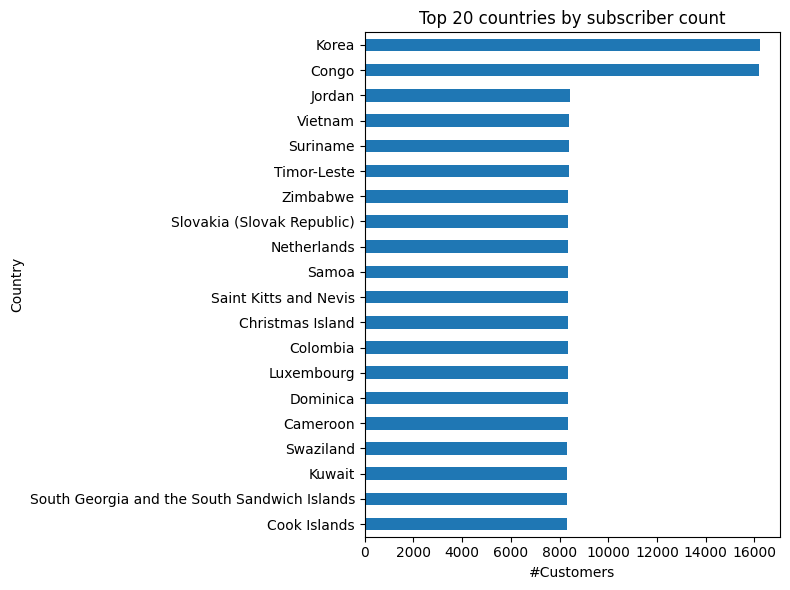

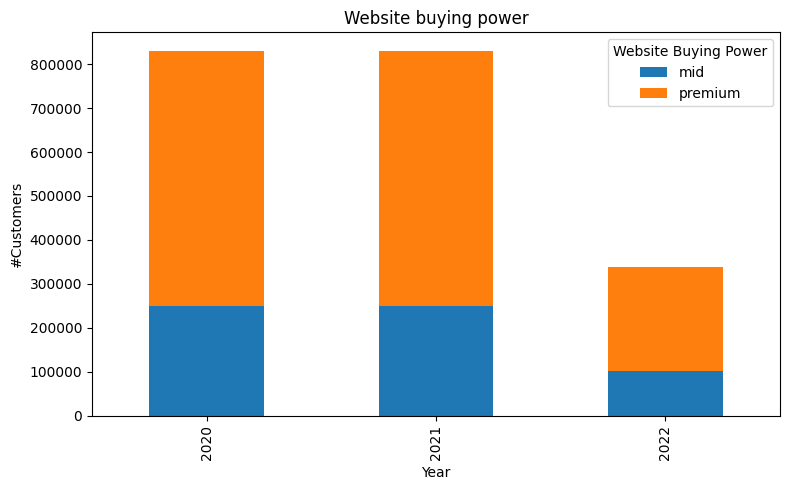

In [15]:
top_countries = main_df['Country'].value_counts().head(20).sort_values(ascending=True)

fig3 = plt.figure(figsize=(8,6))
top_countries.plot(kind='barh')
plt.title('Top 20 countries by subscriber count')
plt.xlabel('#Customers')
plt.tight_layout()
plt.show()


mix = pd.crosstab(main_df['Subscription Date'].dt.year, main_df['Website Buying Power'])
fig4 = plt.figure(figsize=(8,5))
mix.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Website buying power')
plt.xlabel('Year')
plt.ylabel('#Customers')
plt.tight_layout()
plt.show()

**Insights**


No comment soal insightnya, basically masih sama dengan soal nomor 1